In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
from torch.utils.data import DataLoader

from selfpeptide.utils.data_utils import load_binding_affinity_dataframes_jointseqs, SequencesInteractionDataset
from selfpeptide.model.binding_affinity_classifier import Peptide_HLA_BindingClassifier

from selfpeptide.utils.training_utils import eval_classification_metrics

In [23]:
imm_config = {}
config = {}
config["pseudo_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_pseudoseqs_T5/hla_pseudoseq_mapping.csv"
config["hla_prot_seq_file"] = "/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv"
config["binding_affinity_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv'
config["ligand_atlas_binding_df"] = "/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/HLA_Ligand_Atlas_processed.csv"
config["test_size"] = 0.15
config["val_size"] = 0.1
config["seed"]= 0

config["binding_model_checkpoint"] = '/home/gvisona/Projects/SelfPeptides/trained_models/BindingModels/floral-sweep-3/checkpoints/001_checkpoint.pt'
config["binding_model_config"] = '/home/gvisona/Projects/SelfPeptides/trained_models/BindingModels/floral-sweep-3/config.json'
config["dhlap_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/DHLAP_immunogenicity_data.csv'
config["batch_size"] = 16




In [13]:
with open(config["binding_model_config"], "r") as f:
    binding_model_config = json.load(f)
    
for k in binding_model_config:
    if not isinstance(binding_model_config[k], str):
        continue
    if "gvisona/SelfPeptides" in binding_model_config[k]:
        binding_model_config[k] = binding_model_config[k].replace("gvisona/SelfPeptides", "gvisona/Projects/SelfPeptides")

In [14]:
binding_model_config

{'PMA_ln': True,
 'PMA_num_heads': 4,
 'accumulate_batches': 64,
 'batch_size': 16,
 'binding_affinity_df': '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv',
 'cool_down': 0.8,
 'dropout_p': 0.05,
 'early_stopping': True,
 'embedding_dim': 512,
 'experiment_group': 'Binding_affinity_training_LS_joint',
 'experiment_name': 'Binding_model_LS_joint_seeds',
 'hla_embedding_dim': 1024,
 'hla_prot_seq_file': '/home/gvisona/Projects/SelfPeptides/processed_data/HLA_embeddings/HLA_proteins_T5/hla_proteins_mapping.csv',
 'joint_embedder_hidden_dim': 2048,
 'ligand_atlas_binding_df': '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/HLA_Ligand_Atlas_processed.csv',
 'lr': 0.00030967294546198955,
 'ls_alpha': 0.05,
 'max_updates': 20000,
 'min_frac': 0.1,
 'mlp_hidden_dim': 2048,
 'mlp_input_dim': 512,
 'mlp_num_layers': 2,
 'momentum': 0.9,
 'n_attention_layers': 2,
 'nesterov_momentum': True,
 'num_heads': 4,
 'output_dim': 

In [47]:


binding_model = Peptide_HLA_BindingClassifier(binding_model_config, device="cpu") 

gen = binding_model.parameters()
next(gen)
print(next(gen))

Parameter containing:
tensor([[-0.0003,  0.0196,  0.0371,  ..., -0.0427, -0.0466,  0.0059],
        [-0.0257, -0.0540, -0.0290,  ...,  0.0096,  0.0291, -0.0428],
        [ 0.0042, -0.0108, -0.0011,  ...,  0.0397, -0.0233, -0.0298],
        ...,
        [-0.0452,  0.0199,  0.0111,  ...,  0.0536,  0.0146,  0.0135],
        [-0.0315,  0.0212, -0.0539,  ...,  0.0423,  0.0064, -0.0174],
        [ 0.0342, -0.0214, -0.0338,  ...,  0.0379,  0.0463,  0.0081]],
       requires_grad=True)


In [68]:
binding_model.load_state_dict(torch.load(config["binding_model_checkpoint"], map_location="cpu"))
gen = binding_model.parameters()
binding_model.eval()
next(gen)
print(next(gen))

Parameter containing:
tensor([[-0.0516,  0.0270,  0.0410,  ..., -0.0053,  0.0447, -0.0610],
        [-0.0378,  0.0346, -0.0395,  ..., -0.0038, -0.0354, -0.0371],
        [-0.0618, -0.0372,  0.0169,  ..., -0.0202,  0.0488, -0.0283],
        ...,
        [-0.0296, -0.0158,  0.0088,  ..., -0.0132,  0.0181,  0.0533],
        [-0.0011, -0.0004,  0.0189,  ..., -0.0314, -0.0478,  0.0132],
        [-0.0189, -0.0376, -0.0151,  ...,  0.0399, -0.0438, -0.0262]],
       requires_grad=True)


In [69]:
print(next(binding_model.parameters()))

Parameter containing:
tensor([[-0.1902, -0.0761, -0.1093,  ..., -0.5170, -0.0667, -0.8593],
        [ 1.4716, -0.0739,  0.2328,  ..., -1.7281,  0.7716, -1.1154],
        [ 1.0165,  0.4919,  0.3128,  ...,  1.0689,  0.0487, -0.0991],
        ...,
        [ 2.3271, -0.9029,  0.3065,  ..., -0.2454, -2.6924,  1.1082],
        [ 0.9681,  0.7077, -0.4711,  ..., -0.2452,  1.1441, -0.3182],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [70]:
df = pd.read_csv("../processed_data/Binding_Affinity/Zhao_Benchmarking_filtered.csv")
df

,HLA,Peptide,Label,Allele Pseudo-sequence,Allele Protein sequence
0,HLA-B38:01,ARYQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
1,HLA-B38:01,FAYQGHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
2,HLA-B38:01,FRAQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
3,HLA-B38:01,FRYAGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
4,HLA-B38:01,FRYQAHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
...,...,...,...,...,...
363,HLA-A02:06,PLPVSRLVSL,1,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
364,HLA-A02:06,ELNGKNIEDV,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
365,HLA-A02:06,GLKSKTHAVL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
366,HLA-A02:06,ELAAHQKKIL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...


In [71]:
dset = SequencesInteractionDataset(df, hla_repr=["Allele Pseudo-sequence", "Allele Protein sequence"])
dset[0]

['ARYQGHVGA',
 'YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY',
 'MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKTNTQTYRENLRIALRYYNQSEAGSHTLQRMYGCDVGPDGRLLRGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDRTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWEPSSQSTVPIVGIVAGLAVLAVVVIGAVVAAVMCRRKSSGGKGGSYSQAASSDSAQGSDVSLTA',
 1]

In [72]:
loader = DataLoader(dset, batch_size=config['batch_size'], drop_last=False, shuffle=False)

In [73]:
predictions = []
for ix_batch, batch in enumerate(loader):
    peptides, hla_pseudoseqs, hla_protein_seq = batch[:3]
    batch_targets = batch[-1].float()#to(device)

    predicted_logits, _ = binding_model(peptides, hla_pseudoseqs, hla_protein_seq)
    predictions.append(predicted_logits.detach().numpy().flatten())
    
predictions = np.concatenate(predictions)
predictions[:10]

array([ 0.3340607 , -1.1300106 , -0.4126399 , -0.3703063 , -0.42130727,
       -0.61841697, -0.29133642,  0.5537228 , -0.1350303 ,  0.5041134 ],
      dtype=float32)

In [78]:
batch

[('KSMREEYRK',
  'MMARDTAEA',
  'SIVSPFIPLL',
  'PLPVSRLVSL',
  'ELNGKNIEDV',
  'ELVKHGLRAL',
  'ELAAHQKKIL',
  'KTKNFTIDFK',
  'PLPVSRLVSL',
  'GLKSKTHAVL',
  'NLNELVKHGL',
  'PLPVSRLVSL',
  'ELNGKNIEDV',
  'GLKSKTHAVL',
  'ELAAHQKKIL',
  'PLPVSRLVSL'),
 ('YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY',
  'YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY',
  'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YTAMYRNNVAHIDVDTLYIMYQDYTWAVLAYTWH',
  'YYAMYRNNVAQTDVDTLYIRYHYYTWAVWAYTWY',
  'YYAMYRNNVAQTDVDTLYIRYHYYTWAVWAYTWY',
  'YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY',
  'YFAMYGEKVAHTHVDTLYLRYHYYTWAVWAYTWY'),
 ('MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDRNTRNVKAQSQTDRVD

In [75]:
df["Predicted Logits"] = predictions
df

,HLA,Peptide,Label,Allele Pseudo-sequence,Allele Protein sequence,Predicted Logits
0,HLA-B38:01,ARYQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,0.334061
1,HLA-B38:01,FAYQGHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-1.130011
2,HLA-B38:01,FRAQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.412640
3,HLA-B38:01,FRYAGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.370306
4,HLA-B38:01,FRYQAHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.421307
...,...,...,...,...,...,...
363,HLA-A02:06,PLPVSRLVSL,1,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,0.132594
364,HLA-A02:06,ELNGKNIEDV,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,-0.051773
365,HLA-A02:06,GLKSKTHAVL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,0.710871
366,HLA-A02:06,ELAAHQKKIL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,-0.656787


In [76]:

def sigmoid(x):
    return 1/(1 + np.exp(-x))

df["Predictions"] = df["Predicted Logits"].map(sigmoid)
df

,HLA,Peptide,Label,Allele Pseudo-sequence,Allele Protein sequence,Predicted Logits,Predictions
0,HLA-B38:01,ARYQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,0.334061,0.582747
1,HLA-B38:01,FAYQGHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-1.130011,0.244159
2,HLA-B38:01,FRAQGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.412640,0.398279
3,HLA-B38:01,FRYAGHVGA,1,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.370306,0.408467
4,HLA-B38:01,FRYQAHVGA,0,YYSEYRNICTNTYENIAYLRYNFYTWAVLTYTWY,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,-0.421307,0.396204
...,...,...,...,...,...,...,...
363,HLA-A02:06,PLPVSRLVSL,1,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,0.132594,0.533100
364,HLA-A02:06,ELNGKNIEDV,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,-0.051773,0.487060
365,HLA-A02:06,GLKSKTHAVL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,0.710871,0.670593
366,HLA-A02:06,ELAAHQKKIL,0,YYAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,-0.656787,0.341462


In [77]:
metrics = eval_classification_metrics(df["Label"], df["Predictions"], is_logit=False, threshold=0.5)
metrics

{'MCC': -0.0034582078395475704,
 'FPR': 0.5426829268292683,
 'FNR': 0.46078431372549017,
 'Specificity': 0.4573170731707317,
 'NPV': 0.4437869822485207,
 'FDR': 0.4472361809045226,
 'Precision': 0.5527638190954773,
 'Recall': 0.5392156862745098,
 'F1': 0.5459057071960297,
 'BalancedAccuracy': 0.4982663797226208,
 'AUROC': 0.5353000956480153,
 'AUPRC': 0.5566359866727519}

<Axes: xlabel='Label', ylabel='Predictions'>

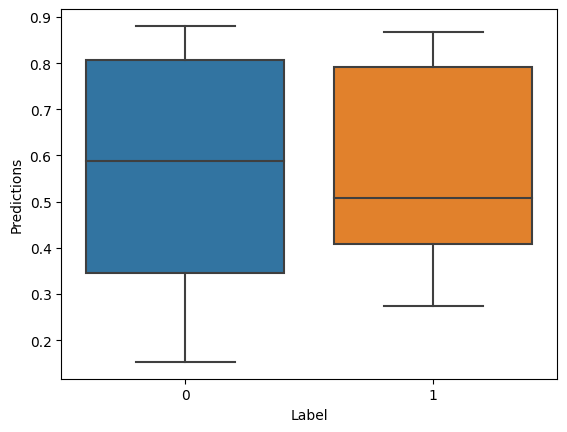

In [67]:
sns.boxplot(df, x="Label", y="Predictions")